### Import all necessary libraries

In [1]:
#!pip install seaborn
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import sklearn
import nltk.collocations 
from nltk import FreqDist, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import string, re
import urllib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
#nltk.download('punkt')
#nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/flatironschool/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/flatironschool/nltk_data...
[nltk_data]   Package words is already up-to-date!


### Read CSV Data

In [2]:
song_list = pd.read_csv('380lyrics.csv')

### Remove Rows with Other and Not Available Genre

In [3]:
song_list.genre.value_counts()

Rock             131377
Pop               49444
Hip-Hop           33965
Not Available     29814
Metal             28408
Other             23683
Country           17286
Jazz              17147
Electronic        16205
R&B                5935
Indie              5732
Folk               3241
Name: genre, dtype: int64

In [4]:
song_list.drop(song_list[song_list.genre == "Other"].index, inplace = True)
song_list.drop(song_list[song_list.genre == "Not Available"].index, inplace = True)
song_list.drop(song_list[song_list.genre == "Indie"].index, inplace = True)
song_list.drop(song_list[song_list.genre == "Folk"].index, inplace = True)
song_list.drop(song_list[song_list.artist == "dolcenera"].index, inplace = True)
song_list.drop(song_list[song_list.artist == "brthhse-onkelz"].index, inplace = True)
song_list.shape

(299523, 6)

In [5]:
song_list.tail()

,index,song,year,artist,genre,lyrics
362232,362232,who-am-i-drinking-tonight,2012,edens-edge,Country,"I gotta say\nBoy, after only just a couple of ..."
362233,362233,liar,2012,edens-edge,Country,I helped you find her diamond ring\nYou made m...
362234,362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth\nLooks ...
362235,362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth\nAnd I'm meas...
362236,362236,amen,2012,edens-edge,Country,I heard from a friend of a friend of a friend ...


### Drop rows with NAN values for column song

In [6]:
song_list.dropna(inplace = True)
song_list.song.isna().sum()
song_list.reset_index(inplace = True)

In [7]:
song_list.tail()

,level_0,index,song,year,artist,genre,lyrics
231786,362232,362232,who-am-i-drinking-tonight,2012,edens-edge,Country,"I gotta say\nBoy, after only just a couple of ..."
231787,362233,362233,liar,2012,edens-edge,Country,I helped you find her diamond ring\nYou made m...
231788,362234,362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth\nLooks ...
231789,362235,362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth\nAnd I'm meas...
231790,362236,362236,amen,2012,edens-edge,Country,I heard from a friend of a friend of a friend ...


### Clean Song titles to remove dashes and capitalize

In [8]:
def clean_song_names(titles_list):
    no_dot = list(map(lambda item: item.replace(".", ""), titles_list))
    no_dash = list(map(lambda item: item.replace("-", " "), no_dot))
    return list(map(lambda item: string.capwords(item), no_dash))

titles_list = song_list.song
final_titles = clean_song_names(titles_list)
len(final_titles)

231791

### Append Clean Song names to DF as a new column and drop old column

In [9]:
new_df = song_list
# new_df.head()
new_titles = final_titles


new_lyr = pd.DataFrame(new_titles)
new_lyr.tail()

final_df = new_df.join(new_lyr)

final_df.drop(columns = ['song', 'level_0', "index"], axis = 1, inplace = True)


In [10]:
final_df.shape

(231791, 5)

In [11]:
final_df.rename(columns = {0: "song"}, inplace = True)
final_df.isna().sum()

year      0
artist    0
genre     0
lyrics    0
song      0
dtype: int64

In [12]:
final_df.shape

(231791, 5)

### Drop Song titles with Nan Values

In [13]:
final_df.genre.value_counts()

Rock          108992
Pop            40466
Hip-Hop        24850
Metal          23759
Country        14387
Jazz            7970
Electronic      7966
R&B             3401
Name: genre, dtype: int64

In [14]:
rock_df = final_df[final_df.genre == "Rock"][:2000]
pop_df = final_df[final_df.genre == "Pop"][:2000]
hip_df = final_df[final_df.genre == "Hip-Hop"][:2000]
metal_df = final_df[final_df.genre == "Metal"][:2000]
jazz_df = final_df[final_df.genre == "Jazz"][:2000]
elec_df = final_df[final_df.genre == "Electronic"][:2000]
country_df = final_df[final_df.genre == "Country"][:2000]
rnb_df = final_df[final_df.genre == "R&B"][:2000]


In [15]:
rock_df.head()

,year,artist,genre,lyrics,song
345,2004,borialis,Rock,"A lot of cats are hatin', slandering makin' ba...",Hourglass
346,2004,borialis,Rock,Somebody tell me why we landed here on the pla...,Why Oh Why
347,2004,borialis,Rock,I'm spittin' with the venom\nTo your soul thro...,Mightier Than The Sword
348,2004,borialis,Rock,Where should I begin cripplin' all you villain...,White Trash
349,2004,borialis,Rock,"Enough of all that, let's switch up the format...",Don T Mean A Thing


In [16]:
final_df.drop(final_df[final_df.genre == "Rock"].index, inplace = True)
final_df.drop(final_df[final_df.genre == "Pop"].index, inplace = True)
final_df.drop(final_df[final_df.genre == "Hip-Hop"].index, inplace = True)
final_df.drop(final_df[final_df.genre == "Metal"].index, inplace = True)
final_df.drop(final_df[final_df.genre == "Jazz"].index, inplace = True)
final_df.drop(final_df[final_df.genre == "Electronic"].index, inplace = True)
final_df.drop(final_df[final_df.genre == "Country"].index, inplace = True)


In [17]:
maybe_df = final_df.append([rock_df, pop_df, hip_df, metal_df, jazz_df, elec_df, country_df])
maybe_df.genre.value_counts()

R&B           3401
Metal         2000
Electronic    2000
Pop           2000
Jazz          2000
Rock          2000
Hip-Hop       2000
Country       2000
Name: genre, dtype: int64

In [18]:
maybe_df.drop(maybe_df[maybe_df.genre == "R&B"].index, inplace = True)
maybe_df = maybe_df.append([rnb_df])

In [19]:
maybe_df.genre.value_counts()

Metal         2000
R&B           2000
Electronic    2000
Pop           2000
Jazz          2000
Rock          2000
Hip-Hop       2000
Country       2000
Name: genre, dtype: int64

In [20]:
maybe_df.reset_index(inplace = True)

In [21]:
maybe_df.drop(columns = ["index"], axis = 1, inplace = True)

In [22]:
maybe_df.head()

,year,artist,genre,lyrics,song
0,2004,borialis,Rock,"A lot of cats are hatin', slandering makin' ba...",Hourglass
1,2004,borialis,Rock,Somebody tell me why we landed here on the pla...,Why Oh Why
2,2004,borialis,Rock,I'm spittin' with the venom\nTo your soul thro...,Mightier Than The Sword
3,2004,borialis,Rock,Where should I begin cripplin' all you villain...,White Trash
4,2004,borialis,Rock,"Enough of all that, let's switch up the format...",Don T Mean A Thing


In [23]:
lyrics_list = list(maybe_df.lyrics)

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
english = list(set(nltk.corpus.words.words()))

def clean_docs_lemma(lyrics_list):
    cleaned = []
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_lemmas = [lemmatizer.lemmatize(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_lemmas)
        cleaned.append(c)
    return cleaned

def clean_docs_stemma(lyrics_list):
    cleaned = []
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_stemmas = [stemmer.stem(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_stemmas)
        cleaned.append(c)
    return cleaned

### First thing we wanted to do is test whether Lemmatizing works better than Stemmatizing

### Lemmed Lyrics Test

In [24]:
lemmed_lyrics = clean_docs_lemma(lyrics_list)

In [25]:
len(set(nltk.word_tokenize(" ".join(lemmed_lyrics))))

62165

In [26]:
X = lemmed_lyrics
y = maybe_df.genre

len(X)

16000

In [27]:
### Split Data in 3 pieces
from sklearn.model_selection import train_test_split  
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=18)
        
len(y1), len(y2)

(8000, 8000)

In [28]:
from sklearn.model_selection import train_test_split  
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=18) 

### Round 1 - Train 3 weakest models

In [29]:
# Train Weakest Models

pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

pipe_ADA = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', AdaBoostClassifier(learning_rate=0.3))
                    ])


pipe_KNN = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', KNeighborsClassifier())
                    ])

# List of pipelines, List of pipeline names
pipelines = [pipe_RF, pipe_ADA, pipe_KNN]
pipeline_names = ['Random Forest', 'ADA', "KNN"]

# Loop to fit each of the three pipelines
for pipe in pipelines:
    print(pipe)
    pipe.fit(X1_train, y1_train)

# Compare accuracies
X1_scores = []
for index, val in enumerate(pipelines):
    tup = (pipeline_names[index], val.score(X1_test, y1_test), val.predict_proba(X1_train), val.predict(X1_train))
    X1_scores.append(tup)
    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X1_test, y1_test)))

Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...m='SAMME.R', base_estimator=None,
          learning_rate=0.3, n_estimators=50, random_state=None))])
Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))])
Random Forest pipeline test accuracy: 0.375
ADA pipeline test accuracy: 0.348
KNN pipeline test accuracy: 0.151


In [33]:
X1_scores[0]

('Random Forest',
 0.3675,
 array([[0.1       , 0.1       , 0.        , ..., 0.8       , 0.        ,
         0.        ],
        [0.1       , 0.        , 0.8       , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.1       , 0.1       , ..., 0.        , 0.        ,
         0.1       ],
        ...,
        [0.6       , 0.1       , 0.        , ..., 0.2       , 0.        ,
         0.        ],
        [0.1       , 0.5       , 0.        , ..., 0.05833333, 0.        ,
         0.1       ],
        [0.8       , 0.1       , 0.        , ..., 0.1       , 0.        ,
         0.        ]]),
 array(['Pop', 'Hip-Hop', 'Metal', ..., 'Country', 'Electronic', 'Country'],
       dtype=object))

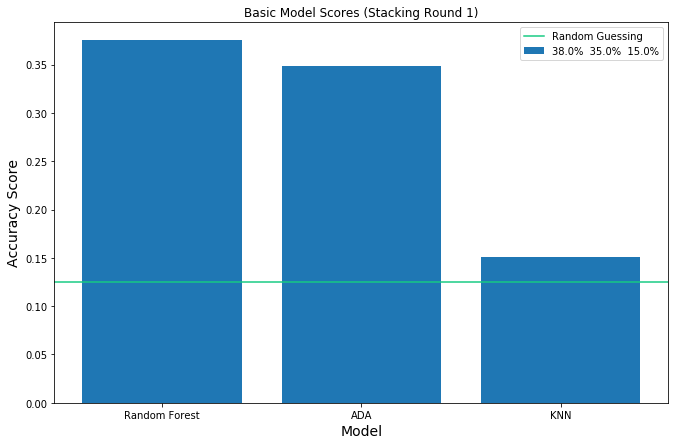

In [36]:
X1_models = [item[0] for item in X1_scores]
X1_accuracy = [item[1] for item in X1_scores]

plt.figure(figsize=(11,7))
plt.title("Basic Model Scores (Stacking Round 1)")
plt.xlabel("Model", fontsize = 14)
plt.ylabel("Accuracy Score", fontsize = 14)
plt.bar(X1_models, X1_accuracy, label = "{}%  {}%  {}%".format(round(X1_scores[0][1], 2)*100, round(X1_scores[1][1], 2)*100, round(X1_scores[2][1], 2)*100))

plt.axhline(y=1/len(set(y)), color='#17CA83', linestyle='-', label = "Random Guessing")
plt.legend()


plt.show()

In [37]:
#Creating Ensemble of 3 weakest learners - Random Forest, Adaboost and KNN
classes = val.classes_
classes

R1_AVG_Scores = (X1_scores[0][2] + X1_scores[1][2] + X1_scores[2][2])/3
R1_df =  pd.DataFrame(R1_AVG_Scores, columns = [item + "_AVG" for item in classes])

In [40]:
R1_df.head()

,Country_AVG,Electronic_AVG,Hip-Hop_AVG,Jazz_AVG,Metal_AVG,Pop_AVG,R&B_AVG,Rock_AVG
0,0.021688,0.077889,0.080408,0.077984,0.172722,0.381309,0.145245,0.042755
1,0.047738,0.123191,0.437547,0.014668,0.093370,0.191871,0.061224,0.030391
2,0.042194,0.108294,0.039385,0.042362,0.407090,0.175590,0.108888,0.076196
3,0.040947,0.109367,0.038918,0.108187,0.108542,0.208857,0.075535,0.309646
4,0.243490,0.040694,0.037418,0.110414,0.273547,0.176094,0.075538,0.042805


In [64]:
from sklearn.model_selection import train_test_split  
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=18) 

### Round 2 Train Good learners

In [65]:
pipe_NB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])

pipe_GBoost = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier(learning_rate=0.3))
                    ])

# List of pipelines, List of pipeline names
pipelines = [pipe_NB, pipe_GBoost]
pipeline_names = ['Multinomail NB', "Gboost"]

# Loop to fit each of the three pipelines
for pipe in pipelines:
    print(pipe)
    pipe.fit(X2_train, y2_train)

# Compare accuracies
X2_scores = []
for index, val in enumerate(pipelines):
    tup = (pipeline_names[index], val.score(X2_test, y2_test), val.predict_proba(X2_train), val.predict(X2_train))
    X2_scores.append(tup)
    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X2_test, y2_test)))

Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])
Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])
Multinomail NB pipeline test accuracy: 0.415
Gboost pipeline test accuracy: 0.417


In [41]:
X2_scores[0]

('Multinomail NB',
 0.415,
 array([[0.06476146, 0.35241613, 0.06331353, ..., 0.13243585, 0.08613732,
         0.10548437],
        [0.1981774 , 0.07245812, 0.04322267, ..., 0.10622388, 0.18648187,
         0.16461711],
        [0.22100511, 0.08076004, 0.0505977 , ..., 0.12314752, 0.11177447,
         0.0915945 ],
        ...,
        [0.19471283, 0.07157141, 0.03604731, ..., 0.09726023, 0.15274023,
         0.16414313],
        [0.11403141, 0.18961607, 0.15143814, ..., 0.09237297, 0.09056385,
         0.10338478],
        [0.0982226 , 0.19033551, 0.10705505, ..., 0.13630554, 0.1378852 ,
         0.10853184]]),
 array(['Electronic', 'Country', 'Jazz', ..., 'Country', 'Electronic',
        'Electronic'], dtype='<U10'))

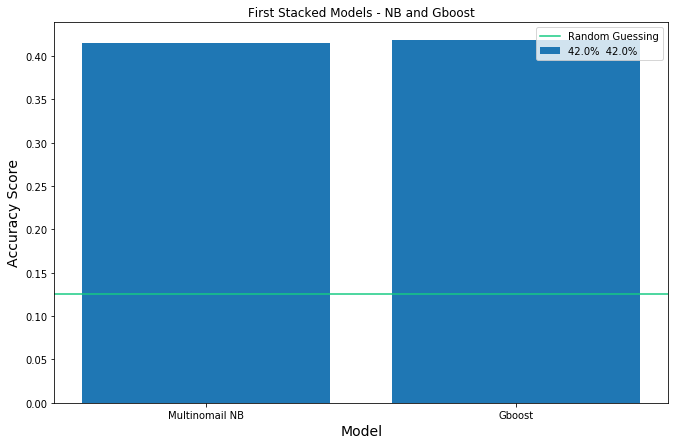

In [63]:
X2_models = [item[0] for item in X2_scores]
X2_accuracy = [item[1] for item in X2_scores]

plt.figure(figsize=(11,7))
plt.title("First Stacked Models - NB and Gboost")
plt.xlabel("Model", fontsize = 14)
plt.ylabel("Accuracy Score", fontsize = 14)
plt.bar(X2_models, X2_accuracy, label = "{}%  {}%".format(round(X2_scores[0][1], 2)*100, round(X2_scores[1][1], 2)*100))

plt.axhline(y=1/len(set(y)), color='#17CA83', linestyle='-', label = "Random Guessing")
plt.legend()


plt.show()

In [42]:
R2_AVG_Scores = (X2_scores[0][2] + X2_scores[1][2])/2
R2_df =  pd.DataFrame(R2_AVG_Scores, columns = [item + "_AVG" for item in classes])

In [43]:
R1_df.shape == R2_df.shape

True

In [44]:
R1_df.head()

,Country_AVG,Electronic_AVG,Hip-Hop_AVG,Jazz_AVG,Metal_AVG,Pop_AVG,R&B_AVG,Rock_AVG
0,0.021688,0.077889,0.080408,0.077984,0.172722,0.381309,0.145245,0.042755
1,0.047738,0.123191,0.437547,0.014668,0.093370,0.191871,0.061224,0.030391
2,0.042194,0.108294,0.039385,0.042362,0.407090,0.175590,0.108888,0.076196
3,0.040947,0.109367,0.038918,0.108187,0.108542,0.208857,0.075535,0.309646
4,0.243490,0.040694,0.037418,0.110414,0.273547,0.176094,0.075538,0.042805


In [45]:
R2_df.head()

,Country_AVG,Electronic_AVG,Hip-Hop_AVG,Jazz_AVG,Metal_AVG,Pop_AVG,R&B_AVG,Rock_AVG
0,0.047769,0.516980,0.035407,0.081689,0.059236,0.098599,0.066628,0.093693
1,0.121772,0.051305,0.024289,0.192795,0.044711,0.092580,0.118648,0.353900
2,0.130299,0.066602,0.029998,0.420444,0.088482,0.096481,0.077741,0.089952
3,0.192157,0.075217,0.023068,0.190702,0.081870,0.215819,0.115592,0.105575
4,0.065138,0.064023,0.043496,0.044308,0.519423,0.092249,0.069692,0.101672


In [46]:
R3_df = pd.concat([R1_df, R2_df])

In [47]:
y3 = pd.concat([y1_train, y2_train])

In [48]:
y3.shape

(12800,)

In [49]:
sum(y3[0:6400] == y1_train), sum(y3[6400:] == y2_train)

(6400, 6400)

### Round 3 - Plug all AVG probabilities as features and train a final NN model

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.


In [51]:
#Converting y_test to categorical

product = y3

le = preprocessing.LabelEncoder() #Initialize. le used as abbreviation fo label encoder
le.fit(product)
print("Original class labels:")
print(list(le.classes_))
print('\n')
product_cat = le.transform(product)  
#list(le.inverse_transform([0, 1, 3, 3, 0, 6, 4])) #If you wish to retrieve the original descriptive labels post production

print('New product labels:')
print(product_cat)
print('\n')


print('One hot labels; 7 binary columns, one for each of the categories.') #Each row will be all zeros except for the category for that observation.
product_onehot = to_categorical(product_cat)
print(product_onehot)
print('\n')

print('One hot labels shape:')
print(np.shape(product_onehot))

Original class labels:
['Country', 'Electronic', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'R&B', 'Rock']


New product labels:
[5 2 4 ... 4 1 1]


One hot labels; 7 binary columns, one for each of the categories.
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


One hot labels shape:
(12800, 8)


In [53]:
X3_train, X3_test, y3_train, y3_test = train_test_split(R3_df[:9000], product_onehot[:9000], test_size=0.2, random_state=123)  

# X_train = X_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)  


print(X3_train.shape, X3_test.shape, y3_train.shape, y3_test.shape)
y3_train

(7200, 8) (1800, 8) (7200, 8) (1800, 8)


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [54]:
#Instantiate Neural Networks Model

random.seed(123)
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(7, input_dim=8, kernel_initializer='normal', activation='tanh')) #2 hidden layers
model.add(layers.Dense(3, activation='tanh'))
model.add(layers.Dense(8, activation='softmax'))

In [55]:
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
model_val = model.fit(X3_train,
                    y3_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X3_test, y3_test))

Train on 7200 samples, validate on 1800 samples
Epoch 1/50
7200/7200 [==============================] - 0s 25us/step - loss: 0.2908 - acc: 0.9360 - val_loss: 0.3140 - val_acc: 0.9306
Epoch 2/50
7200/7200 [==============================] - 0s 25us/step - loss: 0.2899 - acc: 0.9346 - val_loss: 0.3148 - val_acc: 0.9272
Epoch 3/50
7200/7200 [==============================] - 0s 26us/step - loss: 0.2894 - acc: 0.9342 - val_loss: 0.3128 - val_acc: 0.9283
Epoch 4/50
7200/7200 [==============================] - 0s 25us/step - loss: 0.2883 - acc: 0.9354 - val_loss: 0.3127 - val_acc: 0.9272
Epoch 5/50
7200/7200 [==============================] - 0s 29us/step - loss: 0.2877 - acc: 0.9344 - val_loss: 0.3131 - val_acc: 0.9294
Epoch 6/50
7200/7200 [==============================] - 0s 28us/step - loss: 0.2869 - acc: 0.9353 - val_loss: 0.3109 - val_acc: 0.9300
Epoch 7/50
7200/7200 [==============================] - 0s 29us/step - loss: 0.2864 - acc: 0.9350 - val_loss: 0.3114 - val_acc: 0.9283
Epoch 8

### Do final Test with 'Holdout' data

In [60]:
validation_score = model.evaluate(R3_df[9000:], product_onehot[9000:])
validation_score

3800/3800 [==============================] - 0s 12us/step


[0.4376341646282296, 0.8894736842105263]

In [101]:
R3_df.shape

(12800, 8)

### Try a test with different data

In [ ]:
R3_df = pd.concat([R1_df, R2_df])


In [65]:
y_hat = model.predict_classes(R3_df[9000:])

In [61]:
tryit = list(le.inverse_transform(y_hat))
tryit[-10:]

['Electronic',
 'R&B',
 'Electronic',
 'Electronic',
 'Hip-Hop',
 'Metal',
 'Jazz',
 'Pop',
 'Electronic',
 'Metal']

In [67]:
y_hat[-10:]

array([5, 3, 1, 4, 6, 6, 4, 4, 1, 6])

In [68]:
actual = [np.where(item == 1)[0][0] for item in product_onehot[9000:]]
actual[-10:]

[7, 3, 1, 4, 6, 1, 4, 4, 1, 1]

In [69]:
actual_genre = list(le.inverse_transform(actual))
actual_genre[-10:]

['Rock',
 'Jazz',
 'Electronic',
 'Metal',
 'R&B',
 'Electronic',
 'Metal',
 'Metal',
 'Electronic',
 'Electronic']

In [70]:
count = 0
for item in list(zip(tryit, actual_genre)):
        if item[0] == item[1]:
            count += 1
            
count/len(tryit)

0.13

In [ ]:
model_val_dict = model_val.history
model_val_dict.keys()

In [ ]:
results_train = model.evaluate(X_train, y_train)
results_train

In [ ]:
results_test = model.evaluate(X_test, y_test)
results_test

In [ ]:
y_hat_test = model.predict(X_test)
result = y_test - y_hat_test
print(sum(sum(result)))

In [ ]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(lemmed_lyrics, maybe_df.genre, test_size=0.2, random_state=18)

In [ ]:
model.evaluate(X_test, y_test)

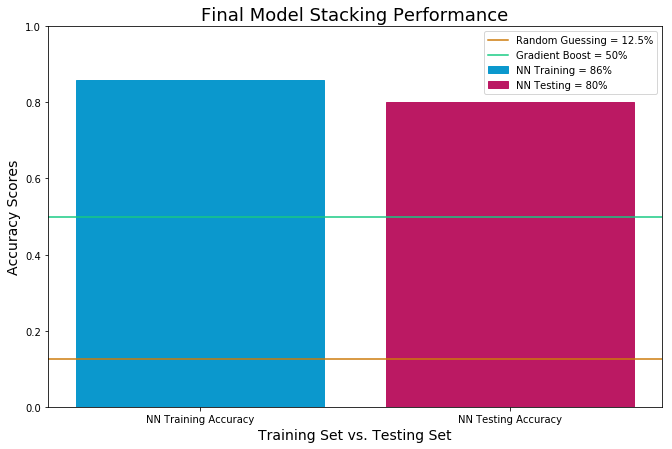

In [100]:
modles_lem = ["NN Training Accuracy", "NN Testing Accuracy"]
accuracy_lem = [0.86, 0.80]


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

plt.figure(figsize=(11,7))
barlist=plt.bar(modles_lem, accuracy_lem)
barlist[0].set_color('#0B98CD')
barlist[0].set_label('NN Training = 86%')
barlist[1].set_color('#BB1963')
barlist[1].set_label('NN Testing = 80%')
plt.axhline(y=1/len(set(y)), color='#CD7B0B', linestyle='-', label = "Random Guessing = 12.5%")
plt.axhline(y=0.5, color='#17CA83', linestyle='-', label = "Gradient Boost = 50%")
plt.xlabel('Training Set vs. Testing Set', fontsize = 14)
plt.ylabel('Accuracy Scores', fontsize = 14)
plt.title('Final Model Stacking Performance', fontsize = 18)
plt.ylim(top=1)
plt.legend()
plt.show()


### We decided to pick Lemmatized over Stemmatized and top three models for further optimization

### Next we want to try using PCA to improve performance and reduce dimentionality

In [ ]:
# tfidf = TfidfVectorizer()
# response = tfidf.fit_transform(lemmed_lyrics)

# PCA_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())
# PCA_df.shape

In [ ]:
# DATA = response  # this comes from above where you're vectorizing tdif dictionary

# non_zero_cols = DATA.nnz / float(DATA.shape[0])
# print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

# percent_sparse = 1 - (non_zero_cols / float(DATA.shape[1]))
# print('Percentage of columns containing 0: {}'.format(percent_sparse))

In [ ]:
# PCA_df.head()

### Creating Features table and Target table and testing first model

In [ ]:
# X_pca = PCA_df
# y_pca = maybe_df.genre

# len(X_pca) == len(y_pca)

In [ ]:
# from sklearn.model_selection import train_test_split  
# X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=18) 

### Try different PCA values and pick a number that preserves sufficient % of variation

In [ ]:
# from sklearn.decomposition import PCA
# pca_1 = PCA(n_components=500)
# pca_2 = PCA(n_components=1000)
# pca_3 = PCA(n_components=1455)
# pca_4 = PCA(n_components=2000)

# principalComponents = pca_1.fit_transform(X_pca)
# principalComponents = pca_2.fit_transform(X_pca)
# principalComponents = pca_3.fit_transform(X_pca)
# principalComponents = pca_4.fit_transform(X_pca)

# print(np.sum(pca_1.explained_variance_ratio_))
# print(np.sum(pca_2.explained_variance_ratio_))
# print(np.sum(pca_3.explained_variance_ratio_))
# print(np.sum(pca_4.explained_variance_ratio_))

### We will test PCA witn n = 1800 on our top 3 models to see if it helps performance

In [ ]:
# pipe_NB_pca = Pipeline([('pca', PCA(n_components=3000, random_state=18)),
#                      ('clf', GaussianNB())
#                     ])

# pipe_RF_pca = Pipeline([('pca', PCA(n_components=3000, random_state=18)),
#                      ('clf', RandomForestClassifier(n_jobs = -1))
#                    ])
                  
# pipe_GBoost_pca = Pipeline([('pca', PCA(n_components=1800, random_state=18)),
#                      ('clf', GradientBoostingClassifier(learning_rate=0.3))
#                     ])


# # List of pipelines, List of pipeline names
# pipelines = [pipe_NB_pca, pipe_RF_pca, pipe_GBoost_pca]
# pipeline_names = ['Multinomial NB', "Random Forest", "Gradient Boost"]

# # Loop to fit each of the three pipelines
# for pipe in pipelines:
#     print(pipe)
#     pipe.fit(X_train_pca, y_train_pca)

# # Compare accuracies
# PCA_scores = []
# for index, val in enumerate(pipelines):
#     tup = (pipeline_names[index], val.score(X_test_pca, y_test_pca))
#     lemmed_basic_scores.append(tup)
#     print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test_pca, y_test_pca)))

In [ ]:
# PCA1800_results = dict(Multinomail_NB = 0.203,
# Gradient_boost = 0.422,
# Random_forest =0.290)



In [ ]:
# n_groups = 3

# basic_mod_name = modles_lem[:3]
# basic_mod_acc = accuracy_lem[:3]
# pca_models_acc = [item[1] for item in PCA1800_results.items()]

# fig, ax = plt.subplots(figsize = (10,8))


# index = np.arange(n_groups)
# bar_width = 0.35

# opacity = 0.5
# error_config = {'ecolor': '0.3'}

# basic_bars = ax.bar(index, basic_mod_acc, bar_width,
#                 alpha=opacity, color='b',
#                 label='Basic Model')

# pca_bars = ax.bar(index + bar_width, pca_models_acc , bar_width,
#                 alpha=opacity, color='r',
#                 label='PCA n_components = 1800')

# ax.set_xlabel('Model Type', fontsize = 14)
# ax.set_ylabel('Accuracy Scores', fontsize = 14)
# ax.set_title('Basic Model vs. PCA with n = 1800 Model Comparison', fontsize = 18)
# ax.set_xticks(index + bar_width / 2)
# ax.set_xticklabels(basic_mod_name)

# plt.axhline(y=1/len(set(y)), color='#17CA83', linestyle='-', label = "Random Guessing")
# ax.legend()
# plt.show()

### We decided that it's not worth using PCA for our models because it increases computational time and doesn't really improve performance

## Let's use GridSearch to try to optimize our  top 3 models!

In [ ]:
Top3_pipelines = [pipe_NB, pipe_GBoost, pipe_RF]
Top3_pipeline_names = ['Multinomail NB', "Gboost", 'Random Forest']

### Grid Search RandomForest

In [ ]:
GS_pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

sorted(GS_pipe_RF.get_params().keys())

rf_param_grid = dict(clf__n_estimators = [10, 30, 100], clf__criterion = ['gini', 'entropy'], 
                    clf__max_depth = [2, 6, 10], clf__min_samples_split = [5, 10],
                    clf__min_samples_leaf = [3, 6])


gs_RF = GridSearchCV(estimator=GS_pipe_RF,
            param_grid=rf_param_grid,
            scoring='accuracy',
            cv=3)

gs_RF.fit(X_train, y_train)

dt_gs_training_score = np.mean(gs_RF.cv_results_['mean_train_score'])
dt_gs_testing_score = gs_RF.score(X_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: {}".format(gs_RF.best_params_))

In [ ]:
Grid_RF_metrics = dict(train_score = dt_gs_training_score, test_score = dt_gs_testing_score, best_params = gs_RF.best_params_)
Grid_RF_metrics

### GridSearch Gboost

In [ ]:
GS_pipe_GB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier())
                    ])
# sorted(GS_pipe_RF.get_params().keys())

GB_params = {
    "clf__learning_rate": [0.2, 0.25],
    "clf__min_samples_split": [4, 5],
    "clf__min_samples_leaf": [6],
    "clf__max_depth":[3],
    "clf__n_estimators":[100, 150]
    }

gs_GB = GridSearchCV(estimator=GS_pipe_GB,
            param_grid=GB_params,
            scoring='accuracy',
            cv=3)

gs_GB.fit(X_train, y_train)

dt_GB_training_score = np.mean(gs_GB.cv_results_['mean_train_score'])
dt_GB_testing_score = gs_GB.score(X_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_GB_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_GB_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: {}".format(gs_GB.best_params_))

In [ ]:
Grid_GB_metrics = dict(train_score = dt_GB_training_score, test_score = dt_GB_testing_score, best_params = gs_GB.best_params_)
Grid_GB_metrics

In [ ]:
hip_lyric = ["dropin my dough real quick. Data Science squad for the win. Drake got nothin on us!"]
jazz_lyric = ["humdinger, babababoo, bababaa from san francisco to georgia, we teach you to code like wah wah"]
rock_lyric = ['when I was young I thought code is not important. Now I learned that i need to know it if I want to grow.']
def test_genre(lyric):
    lemmed_test = clean_docs_lemma(lyric)
    print("This song is definetely {}!".format(gs_GB.predict(lemmed_test)[0]))

In [ ]:
test_genre(rock_lyric)

In [ ]:
basic_scores

In [ ]:
final_top3 = [("GradientBoost with GridSearch", Grid_GB_metrics['test_score']), basic_scores[0], ("Random Forest with GridSearch", basic_scores[2][1])]

In [ ]:
final_top3

In [ ]:
top3_model = [item[0] for item in final_top3]
top3_scores = [item[1] for item in final_top3]

plt.figure(figsize=(10,6))
plt.title("Top3 Models Final Performance", color ='#061152' , fontsize = 20)
plt.ylabel("Accuracy Score", color = '#061152', fontsize = 16)
plt.bar(top3_model, top3_scores, color = "#17CA83", label = "Top 3 Models")

plt.axhline(y=1/len(set(y)), color='#AF2138', linestyle='-', label = "Random Guessing")
plt.legend()

plt.show()

In [ ]:
top_mode_df = pd.DataFrame.from_dict(Grid_GB_metrics['best_params'])
top_mode_df

In [ ]:
!pip install gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models

In [ ]:
import random
test = random.sample(stemmed_lyrics, 7000)
lemmed_lyr = [nltk.word_tokenize(doc) for doc in test]

lemmed_lyr
# test
dictionary = gensim.corpora.Dictionary(lemmed_lyr)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in lemmed_lyr]

### Run Topic Classifier using BoW

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

### Using Topic Classifier Using TF-IDF

In [ ]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=15, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

### WordCloud

In [ ]:
weights = tfidf[bow_corpus[12]]

# Get terms from the dictionary and pair with weights

weights = [(dictionary[pair[0]], pair[1]) for pair in weights]
weights[-35:]



In [ ]:
# !pip install wordcloud
from wordcloud import WordCloud

# Initialize the word cloud

d = {}
for a, x in weights:
    d[a] = x
    
wc = WordCloud(
    background_color="white",
    max_words=2000,
    width = 1024,
    height = 720,
    stopwords=stopwords.words("english")
)

# Generate the cloud

wc.generate_from_frequencies(d)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
d